In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn
import random
import torch.nn.functional as FNT


In [2]:


######################################################
#
#  outils d'affichage -  NE PAS TOUCHER

def ComputeCatPerPixel(XX,YY, weights):
    CategoriePerPixel = XX.copy()
    Larg,Haut = XX.shape
    for i in range(Larg):
        for j in range(Haut):
            x = XX[i][j]
            y = YY[i][j]
            score = compute_score_single(x, y, weights)
            CategoriePerPixel[i][j] = determine_cat(score)
    return CategoriePerPixel

def DessineFond(weights):
    iS = ComputeCatPerPixel(XXXX,YYYY, weights)
    levels = [-1, 0, 1, 2]
    c1 = ('r', 'g', 'b')
    plt.contourf(XXXX, YYYY, iS, levels, colors = c1)

def DessinePoints(x, y, cats):
    c2 = ('darkred','darkgreen','lightblue')
    c = [c2[cat] for cat in cats.numpy()]
    plt.scatter(x.numpy(), y.numpy() ,  s=50, c=c,  marker='o')



##############################################################
#
#  PROJET

# Chaque échantillon a 2 caractéristiques : x et y
# Nous devons apprendre à deviner la catégorie : 0 1 ou 2 suivant ce couple (x,y)

# Pour chaque catégorie i, nous avons 3 paramètres ai, bi, ci d'apprentissage
# Pour un couple (x,y), nous calculons un score pour chaque catégorie :
# ScoreCat0 = a0 * x + b0 * y + c0   (équivaut à 1 neuronne)
# ScoreCat1 = a1 * x + b1 * y + c1   (équivaut à 1 neuronne)
# ScoreCat2 = a2 * x + b2 * y + c2   (équivaut à 1 neuronne)

# Plus simplement :
#         Scores = W . (x,y,1)    W représente 3 neurones, chaque neurone a 3 paramètres internes

# Le plus fort score est associé à la catégorie retenue

# Pour calculer l'erreur, on prend le score Sk de la vrai catégorie k de l'échantillon.
# On calcule Err = Sigma_(j=0 à nb_cat) max(0,Sj - Sk)  avec Sj score de la cat j

# Comment interpréter cette formule :
# La grandeur Sj-Sk nous donne l'écart entre le score de la bonne catégorie et le score de la cat j.
# Si j correspond à k, la contribution à l'erreur vaut 0, on ne tient pas compte de la valeur Sj=k dans l'erreur
# Sinon Si cet écart est positif, ce n'est pas bon signe, car cela sous entend que le plus grand
#          score ne correspond pas à la bonne catégorie et donc on obtient un malus.
#          Plus le mauvais score est grand? plus le malus est important.
#       Si cet écart est négatif, cela sous entend que le score de la bonne catégorie est supérieur
#          au score de la catégorie courante. Tout va bien. Mais il ne faut pas que cela influence
#          l'erreur car l'algorithme doit corriger les mauvaises prédictions. Pour cela, max(0,.)
#          permet de ne pas tenir compte de cet écart négatif dans l'erreur.



In [3]:
def determine_cat(scores):
    return torch.argmax(scores, dim=0)

def compute_score_single(x, y, weights):
    vec    = torch.tensor([x, y, 1], dtype=dtype)
    score  = torch.matmul(weights, vec) # multiplication matricielle sinon broadcasting
    return score


def compute_scores(x, y, weights):
    if x.size() != y.size():
        raise ArgumentException()
    vecs = torch.empty(3, x.size()[0], dtype=dtype)
    vecs[0] = x
    vecs[1] = y
    vecs[2] = torch.ones_like(x)
    scores  = torch.matmul(weights, vecs)
    return scores

def compute_cat_prob(scores):
    # normalising to [-1, 1]
    scores = torch.tanh(scores)
    # Using ReLU requires setting a lower learning rate
    # as it seems to create unstable models.
    scores = FNT.relu(scores)
    return scores
    
def compute_cat_truths(cats, number_cats):
    cat_probs = torch.zeros((number_cats, cats.size()[0]))
    for i in range(len(cats)):
        cat_probs[cats[i].item(), i] = 1.
    return cat_probs


In [4]:
######################################################

# (x,y, category)
data = [[0.5,0.4,0],
        [0.8,0.3,0],
        [0.3,0.8,0],
        [-.4,0.3,1],
        [-.3,0.7,1],
        [-.7,0.2,1],
        [-.4,-.5,1],
        [0.7,-.4,2],
        [0.5,-.6,2]]


XXXX , YYYY = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))



In [5]:
####################################################################

layer_1_func = lambda weights : lambda x, y : compute_scores(x, y, weights)
layer_2      = lambda scores : compute_cat_prob(scores)
loss_func  = lambda cat_truths, cat_probs_pred  : FNT.relu(cat_truths - cat_probs_pred).sum()

dtype = torch.float64

In [6]:
data_tens = torch.tensor(data)

# (x,y, category)
points = data_tens[:, :2]
cats   = data_tens[:, 2].int()

x_train = points[:, 0]
y_train = points[:, 1]
cat_truths = compute_cat_truths(cats, 3)

learning_rate = 0.1

weights = torch.randn((3,3), dtype=dtype, requires_grad=True)


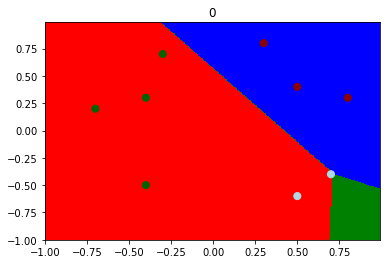

--- epoch 0 : loss = 7.351073292841467


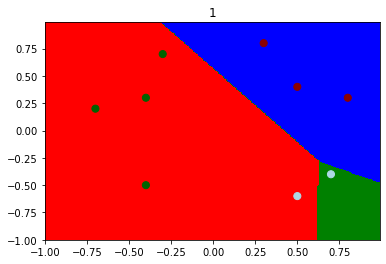

--- epoch 1 : loss = 6.889490054300111


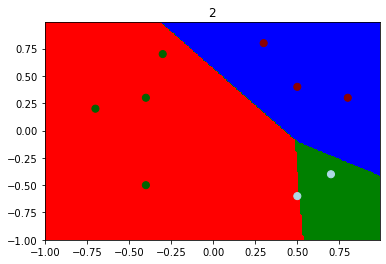

--- epoch 2 : loss = 6.185461491027999


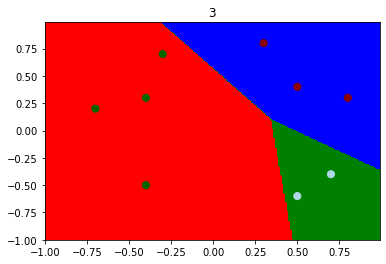

--- epoch 3 : loss = 5.800345251844068


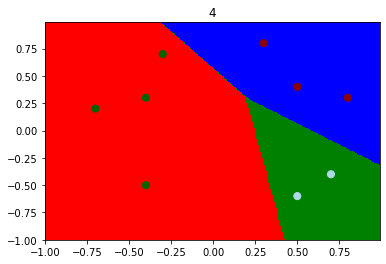

--- epoch 4 : loss = 5.5866731677996215


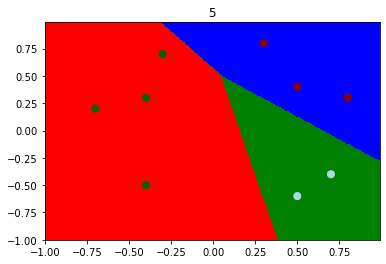

--- epoch 5 : loss = 5.457839790613425


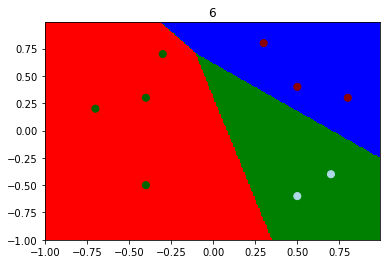

--- epoch 6 : loss = 5.373568841204701


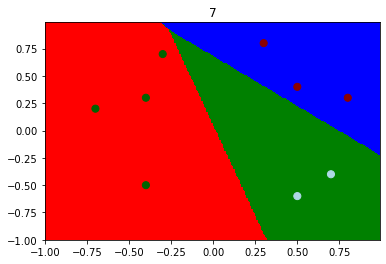

--- epoch 7 : loss = 5.314753842960256


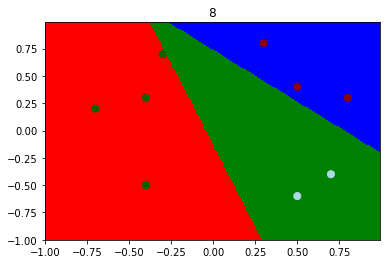

--- epoch 8 : loss = 5.271603139175173


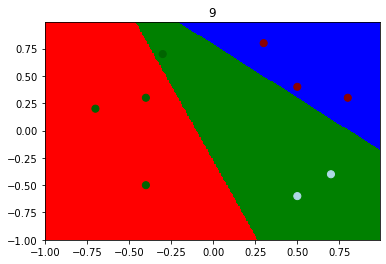

--- epoch 9 : loss = 5.238692945871952


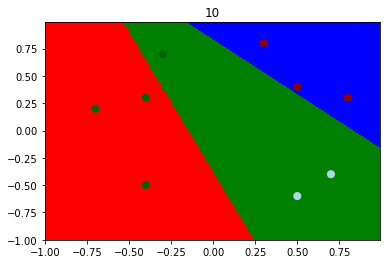

--- epoch 10 : loss = 5.212811435169537


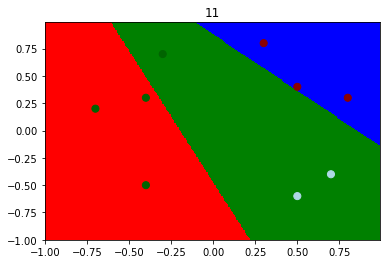

--- epoch 11 : loss = 5.191948257007989


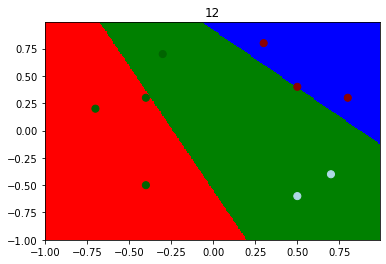

--- epoch 12 : loss = 5.174786007441221


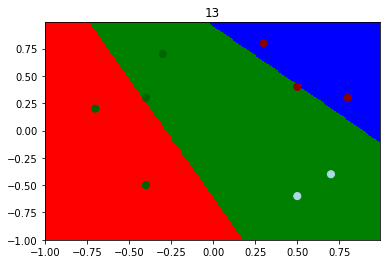

--- epoch 13 : loss = 5.160427697106327


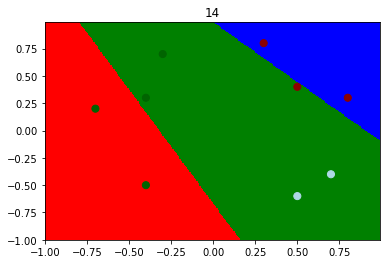

--- epoch 14 : loss = 5.148242571209661


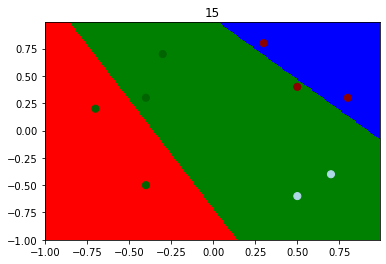

--- epoch 15 : loss = 5.1377747401209195


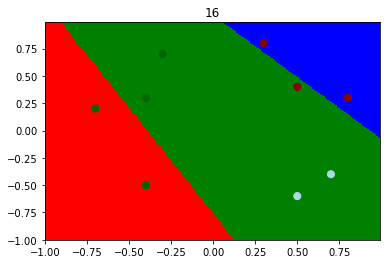

--- epoch 16 : loss = 5.128686825612067


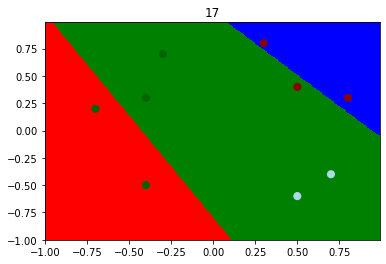

--- epoch 17 : loss = 5.120723980222506


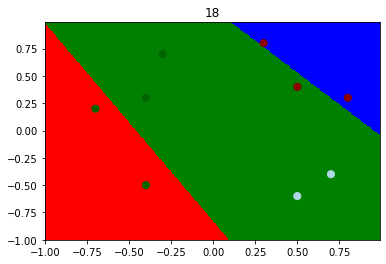

--- epoch 18 : loss = 5.113690210767963


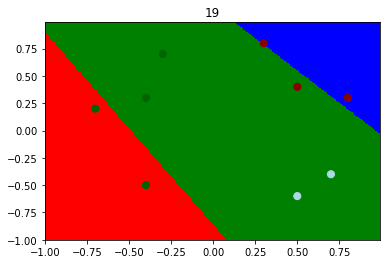

--- epoch 19 : loss = 5.10743238002115


In [7]:

for epoch in range(20):

    DessineFond(weights)
    DessinePoints(x_train, y_train, cats)
    

    plt.title(str(epoch))
    plt.pause(2)  # pause avec duree en secondes

    layer_1 = layer_1_func(weights)
    
    cat_probs_pred = layer_2(layer_1(x_train, y_train))
    
    loss = loss_func(cat_truths, cat_probs_pred)
    
    # A chaque itération, affichez la valeur de a et de l'erreur totale
    print("--- epoch {0} : loss = {1}".format(epoch, loss.item()))

    # Passe BACKWARD :
    # Lorsque le calcul de la passe Forward est terminé,
    # nous devons lancer la passe Backward pour calculer le gradient.
    # Le calcul du gradient est déclenché par la syntaxe :
        
    loss.backward()

    # GRADIENT DESCENT :
    # Effectuez la méthode de descente du gradient pour modifier la valeur
    # du paramètre d'apprentissage a. Etrangement, il faut préciser à Pytorch
    # d'arrêter de calculer le gradient de a en utilisant la syntaxe ci-après.
    # De plus, il faut réinitialiser le gradient de a à zéro manuellement :

    with torch.no_grad() :
        weights -= learning_rate * weights.grad
        weights.grad.zero_()


plt.show()

### Exercice 2

In [8]:


##############################################################
#
#  PROJETS

# chaque échantillon a 2 caractéristiques : x et y
# nous devons apprendre à deviner la catégorie : 0 1 ou 2 pour un couple (x,y)

# extension du cas précédent : Scores = [ x,y,1] * W
# à un calcul en deux étapes :

# T = [x,y,1] * W1
# T = Relu(T)         # on ne garde que les valeurs positives
# Scores = T * W2



# ==============================================


# o La fonction Relu est déjà fourni dans pytorch : torch.nn.functional.relu
# o Pensez à réduire le pas si l'erreur oscille
# o Lancez un affichage toutes les 50 itérations, car l'affichage prend du temps

# =======================================================

# On se propose de travailler avec 2 couches de neurones :
# Input => W1x => Relu => W2x => Scores

# CONSEIL 1
# Si l'on garde pour W1 juste 3 neuronnes, cela ne marchera pas car le reseau n'est pas passez puissant pour apprendre la forme
# => Mettre plusieurs neuronnes sur la couche 1 : à tester  10 / 30 / 100 / 300 / 500 / 1000
# => Garder 3 neuronnes, mais avec plus de poids (paramètre interne)

# CONSEIL 2
# Les scores en sortie peuvent être proches : 3.1 3.2 3.3, ainsi le best score n'est pas vraiment qualitatif.
# On va améliorer la fonction erreur pour qu'elle force le best score à etre plusieurs points au dessus des autres.

# Pour cela, au lieu de faire :
#    Err = Sigma_(j=0 à nb_cat) max(0,Sj-Sk)  avec Sj score de la cat j et Sk score de la bonne catégorie,

# Nous allons choisir :
#    Err = Sigma_(j=0 à nb_cat) max(0,(Sj+2)-Sk) par exemple

# Ainsi, la contribution à l'erreur vaut 0 lorsque Sk > Sj + 2 (il y a deux points d'écart minimum)


In [9]:
# T = [x,y,1] * W1
# T = Relu(T)         # on ne garde que les valeurs positives
# Scores = T * W2

def compute_score_single_2(x, y, w):
    t = compute_score_single(x, y, w[0])
    t = FNT.relu(t)
    t = torch.matmul(w[1], t)
    return t

def compute_cat_pixels_2(XX,YY, w):
    CategoriePerPixel = XX.copy()
    Larg,Haut = XX.shape
    for i in range(Larg):
        for j in range(Haut):
            x = XX[i][j]
            y = YY[i][j]
            score = compute_score_single_2(x, y, w)
            CategoriePerPixel[i][j] = determine_cat(score)
    return CategoriePerPixel


def draw_background(w):
    iS = compute_cat_pixels_2(XXXX,YYYY, w)
    levels = [-1, 0, 1, 2]
    c1 = ('r', 'g', 'b')
    plt.contourf(XXXX, YYYY, iS, levels, colors = c1)


In [10]:
loss_func_2  = lambda cat_truths, cat_probs_pred  : torch.abs(cat_truths - cat_probs_pred).sum()


In [11]:
# (x,y,category)
N = 30    # number of points per class
K = 3     # number of classes
data = np.empty((N * K, K))
for i in range(N):
    r = i / N
    for k in range(K):
        t = ( i * 4 / N) + (k * 4) + random.uniform(0,0.2)
        data[i * K + k] = [ r*np.sin(t), r*np.cos(t) , k]

data_tens = torch.tensor(data)

points = data_tens[:, :2]
cats   = data_tens[:, 2].int()

x_train = points[:, 0]
y_train = points[:, 1]
cat_truths = compute_cat_truths(cats, 3)

In [12]:
number_neurons = 100

w_1 = torch.randn((number_neurons, 3), dtype=dtype, requires_grad=True)
w_2 = torch.randn((K, number_neurons), dtype=dtype, requires_grad=True)
w   = [w_1, w_2]

In [13]:
number_epochs = 200
display_step  = 50

   
start = 1e-4
end   = 1e-6

--- epoch 0 : loss = 117.74048044285604, rate = 0.0001
--- epoch 1 : loss = 117.22491507060886, rate = 9.9505e-05
--- epoch 2 : loss = 116.71191455587197, rate = 9.901e-05
--- epoch 3 : loss = 116.26663815040288, rate = 9.8515e-05
--- epoch 4 : loss = 115.88992196148189, rate = 9.802e-05
--- epoch 5 : loss = 115.54576650349706, rate = 9.7525e-05
--- epoch 6 : loss = 115.24962623259248, rate = 9.703000000000001e-05
--- epoch 7 : loss = 114.94480285848265, rate = 9.653500000000001e-05
--- epoch 8 : loss = 114.69862602004318, rate = 9.604000000000001e-05
--- epoch 9 : loss = 114.47944480568768, rate = 9.554500000000001e-05
--- epoch 10 : loss = 114.28628107382129, rate = 9.505e-05
--- epoch 11 : loss = 114.09033192836863, rate = 9.4555e-05
--- epoch 12 : loss = 113.93094575876667, rate = 9.406e-05
--- epoch 13 : loss = 113.76733785122212, rate = 9.3565e-05
--- epoch 14 : loss = 113.59950082401181, rate = 9.307e-05
--- epoch 15 : loss = 113.42813747654833, rate = 9.2575e-05
--- epoch 16 : 

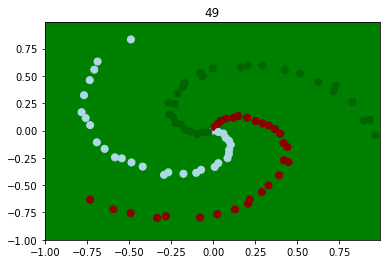

--- epoch 49 : loss = 110.19085826369508, rate = 7.5745e-05
--- epoch 50 : loss = 110.14540985743871, rate = 7.525e-05
--- epoch 51 : loss = 110.09891990691722, rate = 7.4755e-05
--- epoch 52 : loss = 110.05220955600915, rate = 7.426e-05
--- epoch 53 : loss = 110.0054599539526, rate = 7.3765e-05
--- epoch 54 : loss = 109.95840600943649, rate = 7.327000000000001e-05
--- epoch 55 : loss = 109.9110515248122, rate = 7.2775e-05
--- epoch 56 : loss = 109.8639058455233, rate = 7.228e-05
--- epoch 57 : loss = 109.81846531835461, rate = 7.1785e-05
--- epoch 58 : loss = 109.77286059624554, rate = 7.129e-05
--- epoch 59 : loss = 109.7270179340547, rate = 7.0795e-05
--- epoch 60 : loss = 109.68094839236693, rate = 7.03e-05
--- epoch 61 : loss = 109.6360495659753, rate = 6.9805e-05
--- epoch 62 : loss = 109.59077997515897, rate = 6.931e-05
--- epoch 63 : loss = 109.55142906366359, rate = 6.881500000000001e-05
--- epoch 64 : loss = 109.51401603481054, rate = 6.832e-05
--- epoch 65 : loss = 109.47683

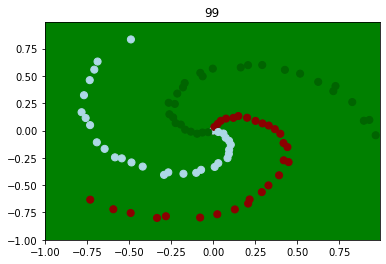

--- epoch 99 : loss = 108.41057634833972, rate = 5.0995e-05
--- epoch 100 : loss = 108.38633147303368, rate = 5.05e-05
--- epoch 101 : loss = 108.36230475547184, rate = 5.0005e-05
--- epoch 102 : loss = 108.3384907877732, rate = 4.951e-05
--- epoch 103 : loss = 108.31488482034845, rate = 4.9015e-05
--- epoch 104 : loss = 108.29148270945224, rate = 4.8519999999999996e-05
--- epoch 105 : loss = 108.26828086893045, rate = 4.8025e-05
--- epoch 106 : loss = 108.24527622576252, rate = 4.753e-05
--- epoch 107 : loss = 108.222466179044, rate = 4.7035e-05
--- epoch 108 : loss = 108.19984856209375, rate = 4.654e-05
--- epoch 109 : loss = 108.17742160740472, rate = 4.6045e-05
--- epoch 110 : loss = 108.15518391418817, rate = 4.5549999999999996e-05
--- epoch 111 : loss = 108.13313447167336, rate = 4.5054999999999995e-05
--- epoch 112 : loss = 108.11127261904763, rate = 4.4559999999999993e-05
--- epoch 113 : loss = 108.08959773771396, rate = 4.4065000000000006e-05
--- epoch 114 : loss = 108.0682150

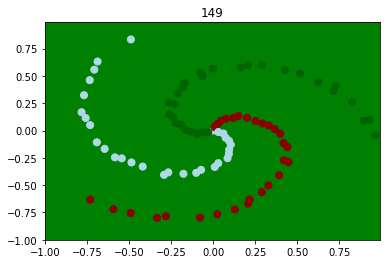

--- epoch 149 : loss = 107.57086102911505, rate = 2.6245000000000004e-05
--- epoch 150 : loss = 107.56112864321594, rate = 2.5750000000000002e-05
--- epoch 151 : loss = 107.55221285310515, rate = 2.5255e-05
--- epoch 152 : loss = 107.54276802613975, rate = 2.476e-05
--- epoch 153 : loss = 107.53351481328801, rate = 2.4265e-05
--- epoch 154 : loss = 107.5239734319125, rate = 2.3769999999999998e-05
--- epoch 155 : loss = 107.5099751626293, rate = 2.3274999999999997e-05
--- epoch 156 : loss = 107.49651651846398, rate = 2.2779999999999995e-05
--- epoch 157 : loss = 107.4836025240137, rate = 2.2284999999999994e-05
--- epoch 158 : loss = 107.47061469717131, rate = 2.1789999999999993e-05
--- epoch 159 : loss = 107.45793260187892, rate = 2.1294999999999992e-05
--- epoch 160 : loss = 107.44555486742381, rate = 2.079999999999999e-05
--- epoch 161 : loss = 107.4334801841737, rate = 2.030499999999999e-05
--- epoch 162 : loss = 107.42170730032453, rate = 1.9809999999999988e-05
--- epoch 163 : loss 

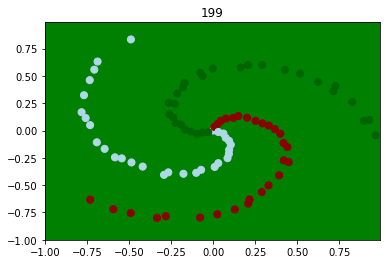

--- epoch 199 : loss = 107.19017352602174, rate = 1.4949999999999984e-06


In [14]:
for epoch in range(number_epochs):
    
    if (epoch + 1) % display_step == 0:
        draw_background(w)
        DessinePoints(x_train, y_train, cats)

        plt.title(str(epoch))
        plt.pause(2)  # pause avec duree en secondes
 
    t = compute_scores(x_train, y_train, w[0])
    t  = FNT.relu(t)
    t = torch.matmul(w[1], t)
    
    cat_probs_pred = compute_cat_prob(t)
    
    loss = loss_func_2(cat_truths, cat_probs_pred)
    
    # print((cat_truths - cat_probs_pred).sum())
    #print(cat_truths)
 
    learning_rate = start + (end - start) * (epoch / number_epochs)
    
    # A chaque itération, affichez la valeur de a et de l'erreur totale
    print("--- epoch {0} : loss = {1}, rate = {2}".format(epoch, loss.item(), learning_rate))
    
    # Passe BACKWARD :
    # Lorsque le calcul de la passe Forward est terminé,
    # nous devons lancer la passe Backward pour calculer le gradient.
    # Le calcul du gradient est déclenché par la syntaxe :
    loss.backward()

    # GRADIENT DESCENT :
    # Effectuez la méthode de descente du gradient pour modifier la valeur
    # du paramètre d'apprentissage a. Etrangement, il faut préciser à Pytorch
    # d'arrêter de calculer le gradient de a en utilisant la syntaxe ci-après.
    # De plus, il faut réinitialiser le gradient de a à zéro manuellement :
  
    with torch.no_grad() :
        w[0] -= learning_rate * w[0].grad
        w[0].grad.zero_()
        w[1] -= learning_rate * w[1].grad
        w[1].grad.zero_()


plt.show()
